In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
import pickle
import os
import torch

print(os.getcwd())
with open('drive/My Drive/BIOMETRIA/new_executions/terravic_lbph_features/train.data', 'rb') as filehandle:
  data_train = pickle.load(filehandle)

with open('drive/My Drive/BIOMETRIA/new_executions/terravic_lbph_features/labels_train.data', 'rb') as filehandle:
  labels_train = pickle.load(filehandle)

with open('drive/My Drive/BIOMETRIA/new_executions/terravic_lbph_features/test.data', 'rb') as filehandle:
  data_test = pickle.load(filehandle)

with open('drive/My Drive/BIOMETRIA/new_executions/terravic_lbph_features/labels_test.data', 'rb') as filehandle:
  labels_test = pickle.load(filehandle)

with open('drive/My Drive/BIOMETRIA/new_executions/terravic_lbph_features/validation.data', 'rb') as filehandle:
  data_val = pickle.load(filehandle)

with open('drive/My Drive/BIOMETRIA/new_executions/terravic_lbph_features/labels_validation.data', 'rb') as filehandle:
  labels_val = pickle.load(filehandle)

hparams = {
    'batch_size':64,
    'num_epochs':300,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':2592,
    'learning_rate':1e-5,
    'log_interval':20,
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

/content


In [114]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np

class CustomDataset(Dataset):
    #initialise the class variables - transform, data, target
    def __init__(self, data, target, transform=None): 
        data_tensor = transform(np.asarray(data))
        self.data =  data_tensor.view(len(data), 1, -1).float()
        # converting target to torch.LongTensor dtype
        self.target = [c-1 for c in target] 

    #retrieve the X and y index value and return it
    def __getitem__(self, index):   
        return (self.data[index], self.target[index])

    #returns the length of the data
    def __len__(self): 
        return len(list(self.data))


transformations = transforms.Compose([transforms.ToTensor()])
train_dataset = CustomDataset(data_train, labels_train, transformations)
test_dataset = CustomDataset(data_test, labels_test, transformations)
val_dataset = CustomDataset(data_val, labels_val, transformations)

train_loader = DataLoader(
    train_dataset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

val_loader = DataLoader(
    val_dataset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

test_loader = DataLoader(
    test_dataset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

In [115]:
# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)

Batch Img shape:  torch.Size([64, 1, 2592])
Batch Label shape:  torch.Size([64])


In [116]:
import torch.nn as nn
network = nn.Sequential(
    nn.Linear(hparams['num_inputs'], 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, hparams['hidden_size']),
    nn.ReLU(inplace=True),
    nn.Linear(hparams['hidden_size'], 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, hparams['num_classes']),
    nn.LogSoftmax()
)
network.to(hparams['device'])
print(network)

Sequential(
  (0): Linear(in_features=2592, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax(dim=None)
)


In [117]:
# Import optmizer 
# https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop
import torch.optim as optim

# Import a functional API for the loss function (use this one !!)
# https://pytorch.org/docs/stable/nn.functional.html#nll-loss
import torch.nn.functional as F

# Optimizer: RMS Prop (use the hparams['learning_rate'] previously defined)
#optimizer = optim.SGD(network.parameters(), lr=hparams['learning_rate'], momentum=0.01)
optimizer=optim.RMSprop(network.parameters(), lr=hparams['learning_rate'])

# Negative Log Likelihood (NLL) Loss criterion from the functional API
criterion=F.nll_loss

# Define the Accuracy metric in the function below by:
  # (1) obtain the maximum for each predicted element in the batch to get the class (it is the maximum index of the num_classes array per batch sample) (look at torch.argmax in the PyTorch documentation)
  # (2) compare the predicted class index with the index in its corresponding neighbor within label_batch 
  # (3) sum up the number of affirmative comparisons and return the summation
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

In [118]:
def train_epoch(epoch, train_loader, network, optimizer, criterion, hparams):

  # Activate the train=True flag inside the model
  network.train()
  
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1

  # For each batch
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()

      data = data.view(data.shape[0], -1)
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

In [119]:
def test_epoch(val_loader, network, hparams):

    # Dectivate the train=True flag inside the model
    network.eval()
    
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in val_loader:

            # Load data and feed it through the neural network
            data, target = data.to(device), target.to(device)
            data = data.view(data.shape[0], -1)
            output = network(data)

            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # WARNING: If you are using older Torch versions, the previous call may need to be replaced by
            #test_loss += criterion(output, target, size_average=False).item()

            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)

    # Average accuracy across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(val_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(val_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [120]:
# Init lists to save the evolution of the training & test losses/accuracy.

train_losses = []
test_losses = []
test_accs = []

# For each epoch
for epoch in range(1, hparams['num_epochs'] + 1):

  # Compute & save the average training loss for the current epoch
  train_loss = train_epoch(epoch,train_loader, network, optimizer, criterion, hparams)
  train_losses.append(train_loss)

  # TODO: Compute & save the average test loss & accuracy for the current epoch
  # TIP: Review the functions previously defined to implement the train/test epochs 
  test_loss,test_accuracy=test_epoch(val_loader, network, hparams)  
  test_losses.append(test_loss)
  test_accs.append(test_accuracy)

Train Epoch: 1 [0/5434 (0%)]	Loss: 2.337425


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [1280/5434 (24%)]	Loss: 2.316753
Train Epoch: 1 [2560/5434 (47%)]	Loss: 2.322413
Train Epoch: 1 [3840/5434 (71%)]	Loss: 2.317825
Train Epoch: 1 [5120/5434 (94%)]	Loss: 2.301625

Test set: Average loss: 9.5263, Accuracy: 199/4318 (5%)

Train Epoch: 2 [0/5434 (0%)]	Loss: 2.319713
Train Epoch: 2 [1280/5434 (24%)]	Loss: 2.313918
Train Epoch: 2 [2560/5434 (47%)]	Loss: 2.308197
Train Epoch: 2 [3840/5434 (71%)]	Loss: 2.315171
Train Epoch: 2 [5120/5434 (94%)]	Loss: 2.301956

Test set: Average loss: 9.4780, Accuracy: 235/4318 (5%)

Train Epoch: 3 [0/5434 (0%)]	Loss: 2.314343
Train Epoch: 3 [1280/5434 (24%)]	Loss: 2.296824
Train Epoch: 3 [2560/5434 (47%)]	Loss: 2.293475
Train Epoch: 3 [3840/5434 (71%)]	Loss: 2.282353
Train Epoch: 3 [5120/5434 (94%)]	Loss: 2.295342

Test set: Average loss: 9.4105, Accuracy: 950/4318 (22%)

Train Epoch: 4 [0/5434 (0%)]	Loss: 2.280823
Train Epoch: 4 [1280/5434 (24%)]	Loss: 2.284315
Train Epoch: 4 [2560/5434 (47%)]	Loss: 2.271229
Train Epoch: 4 [3840/

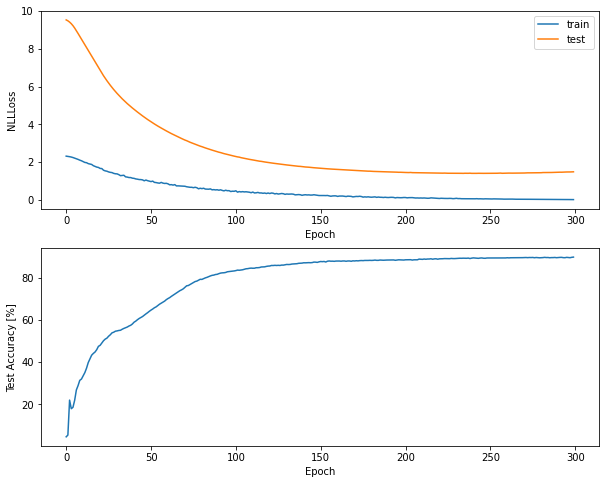

In [121]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(test_accs)

In [123]:
test_loss,test_accuracy=test_epoch(test_loader, network, hparams)


Test set: Average loss: 0.4372, Accuracy: 925/1049 (88%)



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
